- 데이터셋2(감성말뭉치, 단발성 대화 병합)의 테스트 성능이 좋아 최종적으로는 데이터셋2 사용

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import urllib.request
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime
import csv
import requests
from collections import Counter

import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cpu


## 데이터 병합1
- 웰니스 (1로 라벨링)
- 감성말뭉치['기쁨'] + 단발성['행복' , '중립'] (0으로 라벨링)

#### 웰니스 데이터셋

In [ ]:
wellness = pd.read_excel('/content/drive/MyDrive/CUAI 컨퍼런스/data/02)웰니스_대화_스크립트_데이터셋.xlsx')['utterance(2차) ']
wellness.head()

0                     임신해서 우울해
1                아이 가지고 나서 우울해
2      아이 가졌는데 기분 하나도 안 좋고 울적해
3    임신했는데 남편이 하나도 안 챙겨줘서 우울하다
4     진단 결과 안 좋게 나올 것 같아서 우울해 
Name: utterance(2차) , dtype: object

In [ ]:
wellness.dropna(inplace=True)

In [ ]:
wellness = pd.DataFrame(wellness)

# 'label' 열 추가하고 모든 값을 1로 설정
wellness['label'] = 1
wellness

,utterance(2차),label
0,임신해서 우울해,1
1,아이 가지고 나서 우울해,1
2,아이 가졌는데 기분 하나도 안 좋고 울적해,1
3,임신했는데 남편이 하나도 안 챙겨줘서 우울하다,1
4,진단 결과 안 좋게 나올 것 같아서 우울해,1
...,...,...
19764,그래도 잠못자고 불안한건 여전해요.,1
19765,불안함에 항상 시달리니까 잠도 못잤어요.,1
19766,불안하고 초조해서 잠이 안 와.,1
19767,너무 불안하니까 밤만 되면 잠이 안 오고 너무 초조해.,1


In [ ]:
wellness.rename(columns={'utterance(2차) ':'content'}, inplace=True)

#### 감성 말뭉치

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CUAI 컨퍼런스/data/감성대화말뭉치_Training.csv').loc[:, ['감정_대분류', '사람문장1']]
df.head(2)

,감정_대분류,사람문장1
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CUAI 컨퍼런스/data/감성대화말뭉치_Training.csv')
df.head()

,Unnamed: 0,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템문장1,사람문장2,시스템문장2,사람문장3,시스템문장3
0,1,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,일은 왜 해도 해도 끝이 없을까? 화가 난다.,많이 힘드시겠어요. 주위에 의논할 상대가 있나요?,그냥 내가 해결하는 게 나아. 남들한테 부담 주고 싶지도 않고.,혼자 해결하기로 했군요. 혼자서 해결하기 힘들면 주위에 의논할 사람을 찾아보세요.,NaN,NaN
1,2,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,급여가 줄어 속상하시겠어요. 월급이 줄어든 것을 어떻게 보완하실 건가요?,최대한 지출을 억제해야겠어. 월급이 줄어들었으니 고정지출을 줄일 수밖에 없을 것 같아.,월급이 줄어든 만큼 소비를 줄일 계획이군요.,NaN,NaN
2,3,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,회사 동료 때문에 스트레스를 많이 받는 것 같아요. 문제 해결을 위해 어떤 노력을 ...,잘 안 맞는 사람이랑 억지로 잘 지내는 것보단 조금은 거리를 두고 예의를 갖춰서 대...,스트레스받지 않기 위해선 인간관계에 있어 약간의 거리를 두는 게 좋겠군요.,NaN,NaN
3,4,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,관련 없는 심부름을 모두 하게 되어서 노여우시군요. 어떤 것이 상황을 나아질 수 있...,직장 사람들과 솔직하게 이야기해보고 싶어. 일하는 데에 방해된다고.,직장 사람들과 이야기를 해 보겠다고 결심하셨군요.,NaN,NaN
4,5,청년,여성,"진로,취업,직장",해당없음,분노,노여워하는,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,무시하는 것 같은 태도에 화가 나셨군요. 상대방의 어떤 행동이 그런 감정을 유발하는...,상사인 나에게 먼저 인사하지 않아서 매일 내가 먼저 인사한다고!,항상 먼저 인사하게 되어 화가 나셨군요. 어떻게 하면 신입사원에게 화났음을 표현할 ...,NaN,NaN


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46988 (\N{HANGUL SYLLABLE RAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51109 (\N{HANGUL SYLLABLE JANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


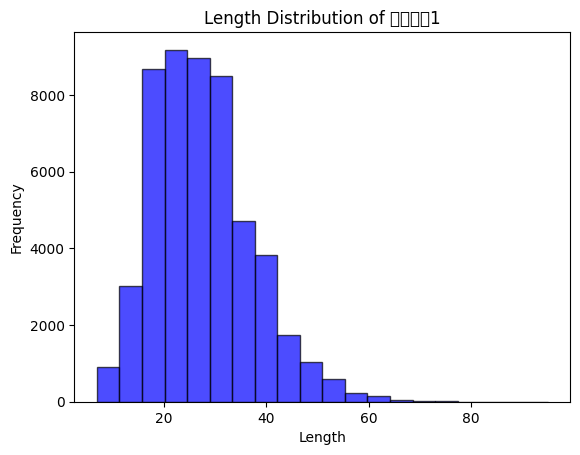

In [ ]:
import matplotlib.pyplot as plt

# '사람문장1' 열의 문자열 길이를 계산
lengths = df['시스템문장1'].str.len()

# 히스토그램 그리기
plt.hist(lengths, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Length Distribution of 사람문장1')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.rename(columns={'감정_대분류': 'label', '사람문장1': 'content'}, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51630 entries, 0 to 51629
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    51630 non-null  object
 1   content  51630 non-null  object
dtypes: object(2)
memory usage: 806.8+ KB


In [ ]:
# binary 데이터로
happy_df = df[df['label'] == '기쁨']

In [ ]:
happy_df
happy_df['label'].value_counts()

기쁨    6126
Name: label, dtype: int64

In [ ]:
happy_df['label'] = 0

<ipython-input-12-0a37b710c057>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  happy_df['label'] = 0


#### 단발성 대화 데이터셋

In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/CUAI 컨퍼런스/data/한국어_단발성_대화_데이터셋.xlsx')[['Sentence', 'Emotion']]
df1 = df1[(df1['Emotion']=='행복') | (df1['Emotion']=='중립')]
df1 = df1['Sentence']

In [ ]:
df1 = pd.DataFrame(df1)
df1['label'] = 0
df1.rename(columns={'Sentence':'content'}, inplace=True)
df1.head()

,content,label
22298,소량은 먹어도 인체에 해롭지 않고요.,0
22299,그래도 청문회 나온 놈들보다는 정직한 대답 한것 같다,0
22300,이런일 터지기전에 이미 계약 했을까?,0
22301,좀더 신중할필요가 있다...,0
22302,이번엔 베터리 색상은?,0


In [ ]:
merged_df = pd.concat([wellness, happy_df, df1], ignore_index=True)
merged_df

,content,label
0,임신해서 우울해,1
1,아이 가지고 나서 우울해,1
2,아이 가졌는데 기분 하나도 안 좋고 울적해,1
3,임신했는데 남편이 하나도 안 챙겨줘서 우울하다,1
4,진단 결과 안 좋게 나올 것 같아서 우울해,1
...,...,...
36665,유느님 내일 이면 해피투게더가하네요~^^,0
36666,승관아~ 너에게 편지를 안 쓸 수가 없네.,0
36667,패떴 개그계 큰 대모 이경실 씨 1탄 잘 봤습니다,0
36668,유재석 오라버니 해피투게더 해피파출소 편 봤어요,0


In [ ]:
merged_df['label'].value_counts()

1    19677
0    16993
Name: label, dtype: int64

### 시각화, 기타 처리

### 데이터가 몇 문장으로 이루어져있는지

In [ ]:
!pip install kss
import kss

In [ ]:
# 예측값, 문장 개수 리스트
num_sentences = []


for text in merged_df['content']:
    # library를 이용해 문장 분리
    sentences = kss.split_sentences(text)

    # 문장 몇개로 나뉘는지 확인
    num_sentences.append(len(sentences))

merged_df['num_sentences'] = num_sentences
merged_df.head()

,content,label,num_sentences
0,임신해서 우울해,1,1
1,아이 가지고 나서 우울해,1,1
2,아이 가졌는데 기분 하나도 안 좋고 울적해,1,1
3,임신했는데 남편이 하나도 안 챙겨줘서 우울하다,1,1
4,진단 결과 안 좋게 나올 것 같아서 우울해,1,1


In [ ]:
merged_df['num_sentences'].value_counts()

1    32982
2     3423
3      225
4       31
5        9
Name: num_sentences, dtype: int64

In [ ]:
merged_df.to_csv('/content/drive/MyDrive/CUAI 컨퍼런스/data/merged_df.csv', index=False) # 저장

### 길이 시각화

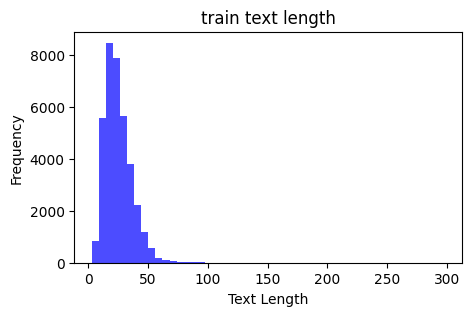

In [ ]:
# 'content' 열의 각 텍스트의 길이 계산
merged_df['text_length'] = merged_df['content'].apply(len)

# 시각화
plt.figure(figsize=(5, 3))
plt.hist(merged_df['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('train text length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
df_length = merged_df['content'].astype(str).apply(len)
print('글 길이 최댓값: {}'.format(np.max(df_length)))
print('글 길이 최솟값: {}'.format(np.min(df_length)))
print('글 길이 중간값: {}'.format(np.median(df_length)))

글 길이 최댓값: 298
글 길이 최솟값: 3
글 길이 중간값: 23.0


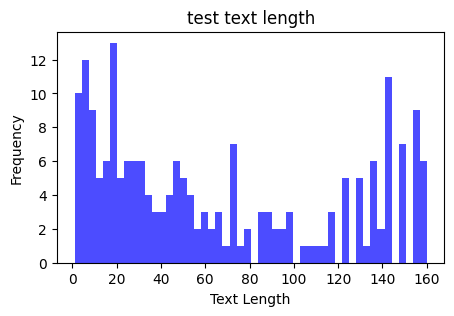

In [ ]:
everytime = pd.read_csv('/content/drive/MyDrive/CUAI 컨퍼런스/data/everytime_depression.csv')

everytime['text_length'] = everytime['content'].apply(len)

# 시각화
plt.figure(figsize=(5, 3))
plt.hist(everytime['text_length'], bins=50, color='blue', alpha=0.7)
plt.title('test text length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# 문자열 아닌 데이터 모두 제거
df_content = [content for content in merged_df['content'] if type(content) is str]

['임신해서 우울해', '아이 가지고 나서 우울해', '아이 가졌는데 기분 하나도 안 좋고 울적해']

In [ ]:
# 나눔고딕 폰트 설치
!apt-get update -qq
!apt-get install fonts-nanum -y

# 폰트 캐시 재구성
!fc-cache -fv
!rm -rf ~/.cache/matplotlib


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.2 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

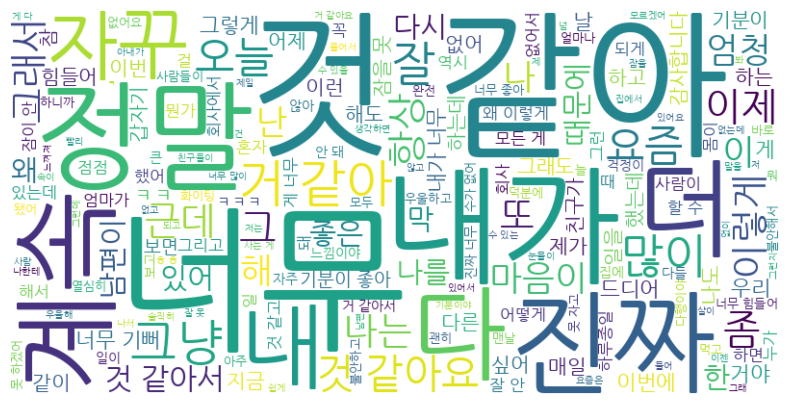

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import font_manager, rc

# 한글 폰트 경로 지정 (예시: 나눔고딕 폰트)
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# DataFrame의 'content' 열에서 텍스트 데이터 추출
text_data = " ".join(merged_df['content'].dropna())

# WordCloud 객체 생성
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text_data)

# 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 데이터 병합2
- 감성 말뭉치['불안', '분노', '상처', '슬픔'] + 단발성 대화['슬픔'] (1로 라벨링)
- 감성 말뭉치['기쁨'] + 단발성 대화['행복', '놀람', '중립'] (0으로 라벨링)

#### depression 데이터

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CUAI 컨퍼런스/data/감성대화말뭉치_Training.csv').loc[:, ['감정_대분류', '사람문장1']]
df.head(2)

,감정_대분류,사람문장1
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.


In [ ]:
depression_df = df[df['감정_대분류'].isin(['불안', '분노', '상처', '슬픔'])]
depression_df.loc[:, 'label'] = 1
depression_df.rename(columns={'사람문장1': 'content'}, inplace=True)

#### 단발성 대화

In [ ]:
df1 = pd.read_excel('/content/drive/MyDrive/CUAI 컨퍼런스/data/한국어_단발성_대화_데이터셋.xlsx')[['Sentence', 'Emotion']]

In [ ]:
depression1 = df1[df1['Emotion'].isin(['슬픔'])]
depression1['label'] = 1
depression1.rename(columns={'Sentence': 'content'}, inplace=True)

In [ ]:
depression = pd.concat([depression_df, depression1], axis=0)
depression

,감정_대분류,content,label,Emotion
0,분노,일은 왜 해도 해도 끝이 없을까? 화가 난다.,1,NaN
1,분노,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나.,1,NaN
2,분노,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,1,NaN
3,분노,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,1,NaN
4,분노,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.,1,NaN
...,...,...,...,...
22293,NaN,별 얘기는 안했는데마음 뒤숭숭하네요 ㅠㅠ,1,슬픔
22294,NaN,소집해제는 24살 2월이라 1년8개월정도남았습니다.....,1,슬픔
22295,NaN,다시만나면 안됬던거야,1,슬픔
22296,NaN,저는 너무 오래해서 엄마한테 맨날 혼나요,1,슬픔


#### non depression 데이터

In [ ]:
non1 = df[df['감정_대분류'].isin(['기쁨'])]
non1['label'] = 0
non1.rename(columns={'사람문장1': 'content'}, inplace=True)

In [ ]:
non2 = df1[df1['Emotion'].isin(['행복', '놀람', '중립'])]
non2['label'] = 0
non2.rename(columns={'Sentence': 'content'}, inplace=True)

In [ ]:
non_depression = pd.concat([non1, non2], axis=0)
non_depression

,감정_대분류,content,label,Emotion
7,기쁨,퇴사한 지 얼마 안 됐지만 천천히 직장을 구해보려고.,0,NaN
9,기쁨,요즘 직장생활이 너무 편하고 좋은 것 같아!,0,NaN
10,기쁨,취업해야 할 나이인데 취업하고 싶지가 않아.,0,NaN
22,기쁨,우리 회사는 정말 사내 분위기가 좋아.,0,NaN
23,기쁨,오늘 내가 다니는 회사가 참 좋은 직장이라는 생각이 들었어.,0,NaN
...,...,...,...,...
33160,NaN,유느님 내일 이면 해피투게더가하네요~^^,0,행복
33161,NaN,승관아~ 너에게 편지를 안 쓸 수가 없네.,0,행복
33162,NaN,패떴 개그계 큰 대모 이경실 씨 1탄 잘 봤습니다,0,행복
33163,NaN,유재석 오라버니 해피투게더 해피파출소 편 봤어요,0,행복


In [ ]:
# 라벨 0과 1 비율을 맞추기 위해 1로 라벨링된 데이터 중 55%만 사용
depression = depression.sample(frac=0.55, random_state=42)
depression

,감정_대분류,content,label,Emotion
8900,상처,옆집 아이가 나보고 아저씨래.,1,NaN
50828,불안,요즘 따라 치매 증상이 더 심해진 것 같아. 무엇에 집중하기가 힘들어.,1,NaN
34687,불안,난 내 소심한 성격이 걱정이야.,1,NaN
45546,슬픔,가족 중에 나를 이해해 주는 사람이 한 명도 없네. 너무 슬프다.,1,NaN
19156,NaN,인터넷 쇼핑도 한 때,1,슬픔
...,...,...,...,...
40927,상처,회사에서 악착같이 버틸 걸 후회가 돼.,1,NaN
40083,불안,아무리 좋은 것을 먹고 좋은 것을 봐도 그것이 계속되면 흥미를 잃게 되는 것 같아.,1,NaN
41242,분노,그렇게 가버리다니. 다 내 잘못이네.,1,NaN
19213,분노,집에만 가면 가족들이 괴롭혀 자꾸 바깥으로 나가게 돼.,1,NaN


In [ ]:
depression_df = pd.concat([depression, non_depression], axis=0, ignore_index=True)
depression_df['label'].value_counts()

1    23108
0    22891
Name: label, dtype: int64

In [ ]:
depression_df

,감정_대분류,content,label,Emotion
0,상처,옆집 아이가 나보고 아저씨래.,1,NaN
1,불안,요즘 따라 치매 증상이 더 심해진 것 같아. 무엇에 집중하기가 힘들어.,1,NaN
2,불안,난 내 소심한 성격이 걱정이야.,1,NaN
3,슬픔,가족 중에 나를 이해해 주는 사람이 한 명도 없네. 너무 슬프다.,1,NaN
4,NaN,인터넷 쇼핑도 한 때,1,슬픔
...,...,...,...,...
45994,NaN,유느님 내일 이면 해피투게더가하네요~^^,0,행복
45995,NaN,승관아~ 너에게 편지를 안 쓸 수가 없네.,0,행복
45996,NaN,패떴 개그계 큰 대모 이경실 씨 1탄 잘 봤습니다,0,행복
45997,NaN,유재석 오라버니 해피투게더 해피파출소 편 봤어요,0,행복


In [ ]:
depression_df.to_csv('/content/drive/MyDrive/CUAI 컨퍼런스/data/merged_df(감정 분류).csv', index=False)